In [ ]:
# https://www.kaggle.com/competitions/cyprus-ai-camp-galaxy-10-classification

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_images_np = np.load("/kaggle/input/cyprus-ai-camp-galaxy-10-classification/train_images.npy")
train_labels_np = np.load("/kaggle/input/cyprus-ai-camp-galaxy-10-classification/train_labels.npy")

test_images_np = np.load("/kaggle/input/cyprus-ai-camp-galaxy-10-classification/test_images.npy")

train_images_np.shape, train_labels_np.shape, test_images_np.shape

((14188, 256, 256, 3), (14188,), (3548, 256, 256, 3))

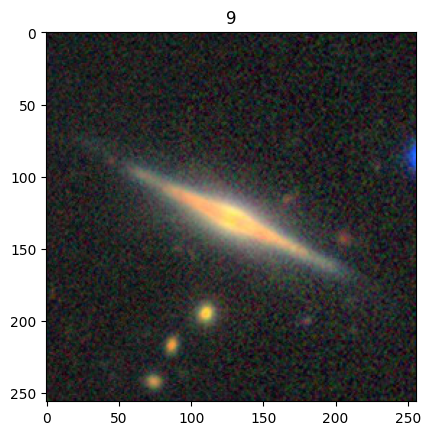

In [3]:
plt.title(train_labels_np[0])
plt.imshow(train_images_np[0], cmap='gray')
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train_images_np, valid_images_np, train_labels_np, valid_labels_np = train_test_split(
    train_images_np, train_labels_np, test_size=0.1, random_state=42, stratify=train_labels_np
)

np.bincount(train_labels_np), np.bincount(valid_labels_np)

(array([ 778, 1334, 1904, 1460,  240, 1471, 1317, 1892, 1025, 1348]),
 array([ 87, 148, 212, 162,  27, 163, 146, 210, 114, 150]))

In [5]:
class GalaxyDataset(Dataset):
    def __init__(self, images_np, labels_np=None, transform=None):
        self.images_np = images_np
        self.labels_np = labels_np
        self.transform = transform

    def __len__(self):
        return len(self.images_np)

    def __getitem__(self, idx):
        img = self.images_np[idx]
        if self.transform is not None:
            img = self.transform(image=img)['image']
        if self.labels_np is None:
            return img
        label = self.labels_np[idx]
        return img, label

In [6]:
transform_train = A.Compose([
    # A.Rotate(limit=(-15, 15)),
    # A.GaussNoise(p=0.25),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),

    A.ToFloat(max_value=255.0),
    A.pytorch.ToTensorV2()
])

transform_infer = A.Compose([
    A.ToFloat(max_value=255.0),
    A.pytorch.ToTensorV2()
])

train_ds = GalaxyDataset(train_images_np, train_labels_np, transform_train)
valid_ds = GalaxyDataset(valid_images_np, valid_labels_np, transform_infer)
test_ds = GalaxyDataset(test_images_np, transform=transform_infer)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

len(train_loader), len(valid_loader), len(test_loader)

(200, 23, 56)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2), # [16, 128, 128]
    
    nn.Conv2d(16, 32, kernel_size=5, padding=2),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2), # [32, 64, 64]

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2), # [64, 32, 32]

    nn.Flatten(),
    nn.Linear(64*32*32, 4096),
    nn.Dropout(0.3),
    nn.Linear(4096, 4096),
    nn.Dropout(0.15),
    nn.Linear(4096, 10)
)

model = model.to(device)

epochs, log_rate = 20, 2

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [9]:
def train_one_epoch(model, criterion, optimizer, train_loader):
    model.train()
    i, rloss, correct, total = 0, 0, 0, 0
    for X, y in (pbar := tqdm(train_loader, desc='Train Loader', leave=False)):
        X, y = X.to(device), y.to(device)
        output = model(X)
        preds = torch.argmax(output, dim=1)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        rloss += loss.item()
        correct += (preds==y).sum().item()
        total += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{correct/total:.5f}'})

    return rloss / i, correct / total

def valid_one_epoch(model, criterion, valid_loader):
    model.eval()
    i, rloss, correct, total = 0, 0, 0, 0
    for X, y in (pbar := tqdm(valid_loader, desc='Valid Loader', leave=False)):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            output = model(X)
            preds = torch.argmax(output, dim=1)
            loss = criterion(output, y)

        i += 1
        rloss += loss.item()
        correct += (preds==y).sum().item()
        total += len(y)
        pbar.set_postfix({'loss': f'{rloss/i:.5f}', 'acc': f'{correct/total:.5f}'})

    return rloss / i, correct / total

def train_loop(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, log_rate):
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    for epoch in tqdm(range(epochs), desc='Epoch'):
        tloss, tacc = train_one_epoch(model, criterion, optimizer, train_loader)
        
        if (epoch+1)%log_rate==0:
            print(f'Epoch: {epoch+1}/{epochs} | lr: {scheduler.get_lr()[0]:.5f}')
            print(f'Train Loss: {tloss:.5f} | Train Acc: {tacc:.5f}')
            
        vloss, vacc = valid_one_epoch(model, criterion, valid_loader)
        
        if (epoch+1)%log_rate==0:
            print(f'Valid Loss: {vloss:.5f} | Valid Acc: {vacc:.5f}')

        history['train_loss'].append(tloss)
        history['train_acc'].append(tacc)
        history['valid_loss'].append(vloss)
        history['valid_acc'].append(vacc)
        scheduler.step()
    return history

In [10]:
history = train_loop(model, criterion, optimizer, scheduler, train_loader, valid_loader, epochs, log_rate)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 2/20 | lr: 0.00198
Train Loss: 7.34533 | Train Acc: 0.23228


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 5.05759 | Valid Acc: 0.25652


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 4/20 | lr: 0.00183
Train Loss: 2.90406 | Train Acc: 0.28138


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 2.41480 | Valid Acc: 0.29951


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 6/20 | lr: 0.00161
Train Loss: 2.81598 | Train Acc: 0.29352


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 2.41700 | Valid Acc: 0.30233


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 8/20 | lr: 0.00133
Train Loss: 2.11549 | Train Acc: 0.33111


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 2.06646 | Valid Acc: 0.32911


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 10/20 | lr: 0.00102
Train Loss: 1.91816 | Train Acc: 0.36479


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 1.83522 | Valid Acc: 0.36998


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 12/20 | lr: 0.00071
Train Loss: 1.79615 | Train Acc: 0.39635


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 1.77964 | Valid Acc: 0.39676


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 14/20 | lr: 0.00043
Train Loss: 1.65761 | Train Acc: 0.42266


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 1.75070 | Valid Acc: 0.41508


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 16/20 | lr: 0.00021
Train Loss: 1.54229 | Train Acc: 0.45485


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 1.57632 | Valid Acc: 0.43270


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 18/20 | lr: 0.00006
Train Loss: 1.44777 | Train Acc: 0.48579


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 1.52483 | Valid Acc: 0.47075


Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Train Loader:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 20/20 | lr: 0.00000
Train Loss: 1.38955 | Train Acc: 0.50505


Valid Loader:   0%|          | 0/23 [00:00<?, ?it/s]

Valid Loss: 1.50460 | Valid Acc: 0.47287


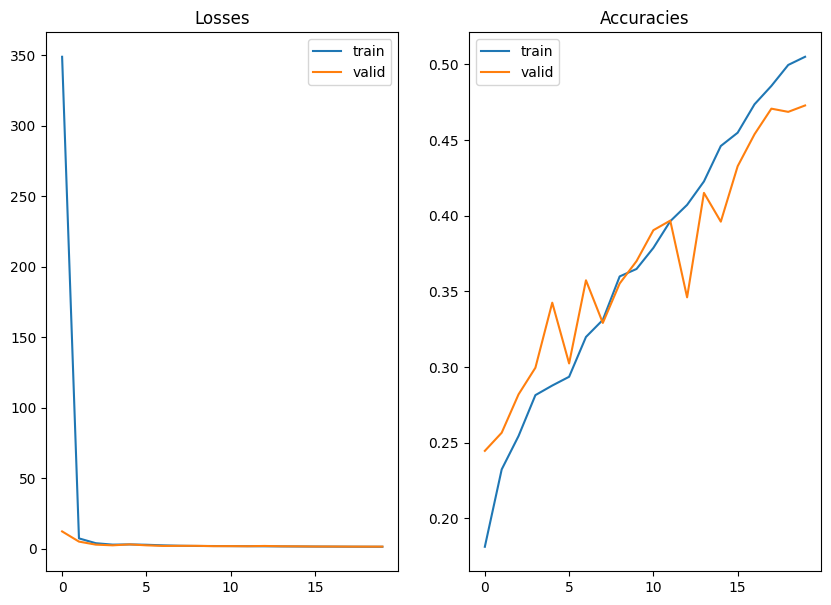

In [11]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), history['train_loss'], label='train')
plt.plot(range(epochs), history['valid_loss'], label='valid')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history['train_acc'], label='train')
plt.plot(range(epochs), history['valid_acc'], label='valid')
plt.title('Accuracies')
plt.legend()

plt.show()

In [12]:
def infer(model, test_loader):
    model.eval()
    all_preds = []
    for X in tqdm(test_loader, desc='Test Loader'):
        X = X.to(device)
        with torch.no_grad():
            output = model(X)
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().tolist())
    return np.array(all_preds)

In [13]:
y_pred = infer(model, test_loader)

Test Loader:   0%|          | 0/56 [00:00<?, ?it/s]

In [14]:
subm = pd.read_csv("/kaggle/input/cyprus-ai-camp-galaxy-10-classification/sample_submission.csv")
subm['Category'] = y_pred

subm.to_csv("submission.csv", index=False)
subm.head()

,Id,Category
0,0,2
1,1,7
2,2,7
3,3,8
4,4,0


In [15]:
subm['Category'].value_counts()

Category
7    732
2    623
9    491
6    427
3    412
8    291
1    249
5    225
0     81
4     17
Name: count, dtype: int64